In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch as torch
import networkx as nx
from scipy.linalg import block_diag
import matplotlib.animation as animation

In [2]:
%matplotlib inline

In [3]:
num_neurons = 12 # number of neurons in the system

# imagine that I have an array of neurons.  I will represent this array 
# through various other arrays that each correspond with a particular
# aspect of the neurons.  First, we set up an array with numbers that 
# show how long ago the neuron at that index fired.  
# A '0' represents that they are firing at the time we observe them,
# and a '4' means they fired four timesteps ago.  I'll call this
# vector the 'fire_history' of the neuron.

init_firehist_lowerbound = 0
init_firehist_upperbound = 5
fire_history = torch.randint(init_firehist_lowerbound,init_firehist_upperbound,(num_neurons,)) 

In [4]:
# now we need to imagine that we have an array corresponding
# to the neron's particular polarization or f_val (fire_value) level. 
# We'll assume that 0 is a neutral state, and that each neuron
# will fire if it's f_val goes above fire_threshold.

init_fval_lowerbound = -4
init_fval_upperbound = 5
f_val = torch.rand((num_neurons,))*(init_fval_upperbound-init_fval_lowerbound)+init_fval_lowerbound 

fire_threshold = 4

In [5]:
# we can immagine that these neurons are set up on a grid 
print(fire_history.view(4,3))
print(f_val.view(4,3))

tensor([[3, 3, 0],
        [3, 4, 0],
        [1, 2, 2],
        [1, 1, 3]])
tensor([[-0.8201, -3.0407,  4.1005],
        [ 4.7669,  3.5402, -3.8396],
        [-1.6086,  3.8436, -2.6774],
        [-0.6504, -0.8648,  0.5733]])


In [6]:
# Hypercube code from Eelco Hoogendoorn on Stack Exchange.
# here to consider potentially using it to create a 'building block'
# for higher dimensional problems.  Note that
def hypercube(ndim, diagonal=False):
    """Recursively construct the edge-connectivity of a hypercube

    Parameters
    ----------
    ndim : int
        Dimension of the hypercube
    diagonal : bool
        Value of the diagonal
        If True, vertices are considered connected to themselves

    Returns
    -------
    ndarray, [2**ndim, 2**ndim], bool
        connectivity pattern of the hypercube
    """
    if ndim == 0:
        return np.array([[diagonal]])
    else:
        D = hypercube(ndim-1, diagonal)
        I = np.eye(len(D), dtype=D.dtype)
        N = I*0
        return np.block([
            [D, I],
            [I, D]
        ])
    
def extend(A,n):
    '''Creates an extension of A n times, allowing
       for connections both directions.
       
       Note that an n-dimensional hypercube can be created
       by composing extend with the [1] array 
       
    Would take in the deminsions of the lattice to start with:
    Then these would need to be able to be joined together
    to form a relavant lattice design: think that the cell bodies are
    located at specific points on a lattice,
    and that they can connect to other cell bodies
    by extending dendrites out along the edges.  once a dendrite
    is at a 'node' (cell body) it can also extend to the neighboring
    cells around that cell body.   
       '''
    # first, create a replication of A along the diagonal n times.
    D = block_diag(*([A] * n))
    # then add the 'lower and upper connections'
    b = np.ones((1, (n-1)*len(A)))[0]
    # return the combined diagonalized block matrix with the connections
    return D + np.diag(b,len(A)) + np.diag(b,-len(A))

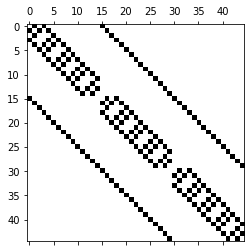

C:\Users\nealdm\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


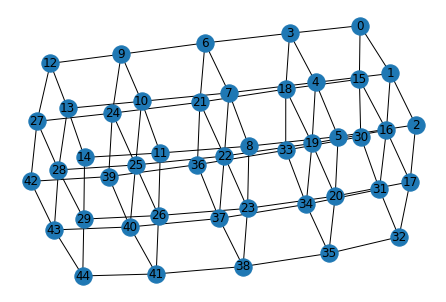

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]], dtype=torch.float64)

In [7]:
A = np.array([0])
t = extend(A,3)
t = extend(t,5)
t = extend(t,3)
# t = extend(t,3)

plt.spy(t)
plt.show()
G = nx.from_numpy_matrix(np.array(t)) 
nx.draw(G, with_labels=True)
plt.show()
# B = hypercube(5,diagonal=True)
# plt.spy(B)
# plt.show()
# G = nx.from_numpy_matrix(np.array(B)) 
# nx.draw(G, with_labels=True)
# plt.show()
torch.tensor(t)

In [8]:
# Now we need two more matrices before we can teach this group
# of neurons how to fire properly to perform useful computations.
# We need to establish the matrices that represent connections.
# The first matrix will represent how much connections between 
# two neurons are being 'used' (large positive value if the connection)
# has been 'useful' in predicting the firing of the next neuron
# and a low value or zero if it's firing does not correspond very well.
# I will call this the connection importance or the 'importance' matrix.
# The values of the importance matrix will be clamped (clipped) to some
# constant (defined as saturated_importance below with an explanation 
# of it's purpose)

# It is important that to begin, connections happen locally.  Thus,
# I will write a function that will take in the f_val.view() tensor,
# look at it's shape, and create an adjacency matrix 
# that fully connects neurons to neurons that are locally nearby (with
# horizontal wraparound at the edges for this simple 1-d example.)

def create_importance(t,self_reference = False):
    '''Takes in a tensor t.
    Returns the initial importance connections matrix.
    This is essentially the origional adjacency matrix.
    '''
    # T will contain the final tensor.  It will be built up by
    # using the shape of the passed in tensor
    # as a hint of how to create the adjacency matrix to match
    # the shape: essentially it creates a 'lattice'
    # matching the dimensions given.
    T = []
    # self_reference establishes if the nodes connect to themselves.
    # if they do, the diagonal is one- otherwise it is zeros.
    if self_reference: T = [1]
    else: T = [0]
    
    # now I build up the lattice using extend.
    for i in t.shape:
        T = extend(T,i)
    
    return torch.tensor(T)

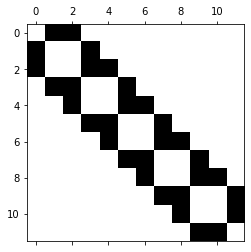

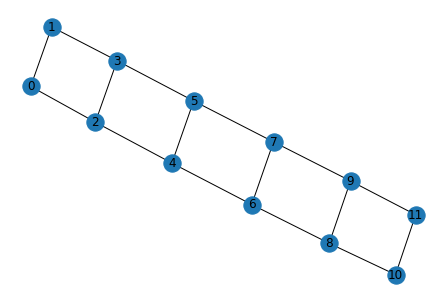

In [10]:
%matplotlib inline

# the following will visualize the adjacency matrix we are working on.
I = create_importance(f_val.view(2,6))
plt.spy(I)
plt.show()

# it resembles a lattice, with a 'neuron cell body' at each intersection point
# of the grid.

G = nx.from_numpy_matrix(np.array(I)) 
nx.draw(G, with_labels=True)
plt.show()

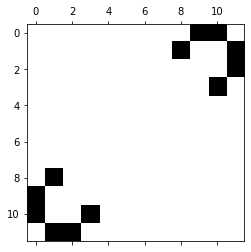

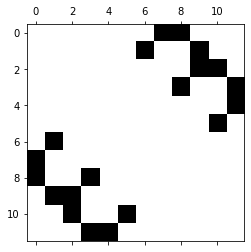

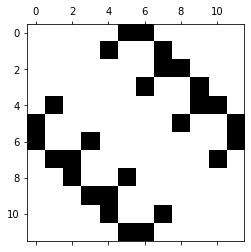

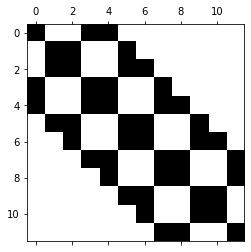

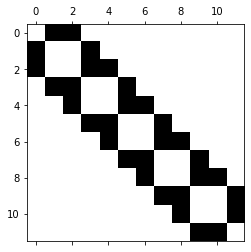

In [11]:
# I may also need to use the fact that with the adjacency matrix,
# I can see how strong a connection is to another node.
I1 = np.array(I).astype(int)
I2 = np.array(I@I).astype(bool).astype(int)
I3 = np.array(I@I@I).astype(bool).astype(int)
I4 = np.array(I@I@I@I).astype(bool).astype(int)
I5 = np.array(I@I@I@I@I).astype(bool).astype(int)

plt.spy(I5-10*I4-10*I3-10*I2-10*I1>0)
plt.show()
plt.spy(I4-10*I3-10*I2-10*I1>0)
plt.show()
plt.spy(I3-10*I2-10*I1>0)
plt.show()
plt.spy(I2-10*I1>0)
plt.show()
plt.spy(I1)
plt.show()

In [12]:
# I = np.array(create_importance(f_val.view(4,3))).astype(int)
# I2 = (I@I).astype(bool).astype(int)
# I3 = (I2@I).astype(bool).astype(int)
# plt.spy(I3)
# plt.show()
# plt.spy(I@I@I)
# plt.show()

# G = nx.from_numpy_matrix(I3) 
# nx.draw(G, with_labels=True)
# plt.show()

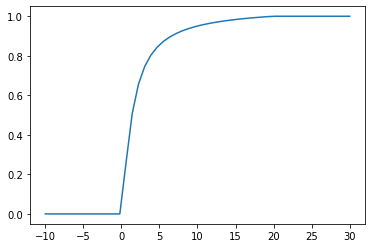

0

In [13]:
# The second matrix I will need to create represents the ammount of
# Neurotransmitter that would be released at a particular connection
# upon firing.  It will be called NT, and is created by continuously
# applying a function to each of the values of the first
# matrix.  The values in NT can be considered the 'neurotransmitter 
# strength'.
# If a neuron fires, then the fact it fires shuld not be influenced 
# by what the f_val was at the time of firing, but rather the effect 
# of a neuron's firing on a following neuron should increase or 
# decrease corresponding to a shifted scaled arctangent of 
# the importance matrix; where it is cut off between 0 and some
# end point (I'll use 20 here) 
# This NT matrix is a  weighting of the importance matrix, and a
# particular value therein will increase with each time the 
# first neuron fired within apply_threshold ticks of the second neuron,
# (as a function of the importance matrix increasing as this occurs)
# and will max out at 1 after the importance reaches the endpoint.
# The fact that the arctan function levels off near the top means
# that even if neuron 'a' missfires every now and again but is usually
# pretty useful, then the TF value will still be high.

# TODO: >is there need to make the values 'soft' on startup? (squish arctan more, clip at ends?)

# I need to parallelize the whole thing
saturated_importance = 20
minimum_importance = -2
x_lin = np.linspace(-10,saturated_importance+10)
f = lambda x: (np.arctan(x*2/3)*2/np.pi)/(np.arctan(saturated_importance*2/3)*2/np.pi)
fun = lambda x: f(x) if (0<=x<=saturated_importance) else (0 if x < 0 else 1)
fun_v = np.vectorize(fun)
plt.plot(x_lin,[fun(x) for x in x_lin])
plt.show()

fun(-1)

In [14]:
NT = fun_v(I)

In [15]:
# The neurons need a threshold for hebbian learning to work.
# I'll call this value apply_threshold.
# This represents the number of ticks that can have passed
# between the time neuron 'a' affected neuron 'b'
# and neuron 'b' fired in order for it to still strengthen
# the connection between 'a' and 'b'.
# After apply_threshold+1 ticks from 'a's firing, the connection
# will be weakened instead of strengthened.
# If neuron i correctly aids in the prediction of the neuron j's
# firing, it will be strengthened by strengthen_const/fire_history[i]
# such that if it were directly beforehand, the fire_history
# value is 1 and the weight increases by strengthen_const.
# If it aided further back, say 5 ticks back, only strengthen
# the weight a little, by strengthen_const/5.
# If the number of ticks exceeds apply_threshold, then the connection 
# is unhelpful, and it should be weakened by ammount weaken_const.

apply_threshold = 10 # the number of ticks that can occur for weights to be strengthened.

In [16]:
# perhaps if you want to allow the network to 'work online', then
# if you add a neuron that essentially says 'accept input', followed
# by an input value, then the agent can 'learn' to accept multiple
# frames and do predictions on them in order.

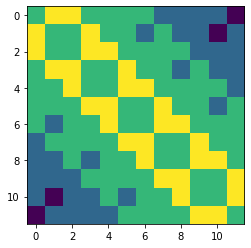

array([[2., 3., 3., 2., 2., 2., 2., 1., 1., 1., 1., 0.],
       [3., 2., 2., 3., 2., 2., 1., 2., 1., 1., 0., 1.],
       [3., 2., 2., 3., 3., 2., 2., 2., 2., 1., 1., 1.],
       [2., 3., 3., 2., 2., 3., 2., 2., 1., 2., 1., 1.],
       [2., 2., 3., 2., 2., 3., 3., 2., 2., 2., 2., 1.],
       [2., 2., 2., 3., 3., 2., 2., 3., 2., 2., 1., 2.],
       [2., 1., 2., 2., 3., 2., 2., 3., 3., 2., 2., 2.],
       [1., 2., 2., 2., 2., 3., 3., 2., 2., 3., 2., 2.],
       [1., 1., 2., 1., 2., 2., 3., 2., 2., 3., 3., 2.],
       [1., 1., 1., 2., 2., 2., 2., 3., 3., 2., 2., 3.],
       [1., 0., 1., 1., 2., 1., 2., 2., 3., 2., 2., 3.],
       [0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 2.]])

In [17]:
plt.imshow(I1+I2+I3+I4+I5)
plt.show()
np.array(I)+I2+I3+I4+I5

In [18]:
print(fire_history.view(2,6))
print(f_val.view(2,6))

tensor([[3, 3, 0, 3, 4, 0],
        [1, 2, 2, 1, 1, 3]])
tensor([[-0.8201, -3.0407,  4.1005,  4.7669,  3.5402, -3.8396],
        [-1.6086,  3.8436, -2.6774, -0.6504, -0.8648,  0.5733]])


In [19]:
I1

array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [21]:
# Hebbian Learn:

#I now have the pieces I need.

fval_lowerbound = -1
fval_upperbound = 2
f_val = torch.rand((num_neurons,))*(fval_upperbound-fval_lowerbound)+fval_lowerbound 

fire_threshold = .6 # threshold at which if f_val is greater than it, neuron 'fires'
decay_val = .4

init_firehist_lowerbound = 0
init_firehist_upperbound = 6
fire_history = torch.randint(init_firehist_lowerbound,init_firehist_upperbound,(num_neurons,)) 

apply_threshold = 4 # threshold at which Importance is increased/decreased
                    # according to the fire_history

strengthen_const = 6
weaken_const = -1
I = create_importance(f_val.view(2,6))
I = I.clamp(minimum_importance,saturated_importance)
NT = torch.tensor(fun_v(I))

# Make sure to clip the importance matrix every time to saturated_importance for
# the upper bound, and also clip it at minimum_importance for the lower bound
saturated_importance = 20
minimum_importance = -2
ticks = 50
freq = 10

# print("f_val")
# plt.plot(f_val)
# plt.show()
# plt.imshow(NT)
# plt.show()

matrices = []
for tic in range(ticks):
    
    
    if tic%freq==0: f_val[0:2] = torch.tensor([2,2]);
    if tic%freq==freq-1: f_val[10:12] = torch.tensor([2,2]);    
       
    matrices.append([I.clone(),NT.clone(),f_val.view(2,6).detach().clone()])
       
    # first fire the neurons that need to fire:
    # use a mask to find which neurons are firing
    firing = f_val >= fire_threshold
    # set the neurons that fired to zero
    f_val[firing] = 0
    # then send the signal by changing the f_val of
    # each neuron the appropriate
    f_val = f_val.double() + NT@firing.double()

    # next step the firing history of all neurons forward
    # by one
    fire_history = fire_history + 1

    # Now for the hebbian learning step:
    # now update the importance of each existing connection;
    # first: based on how apply_threshold compares to
    # the fire_history of all the connections
    # which caused the neurons that are firing to  ##TODO: add the lapse period of time for which a neuron will not fire after firing
    # fire.                                        # Make sure that if a neuron 

    # create boolean indecies of the neurons that recently fired
    recently_fired = fire_history<=apply_threshold 

    # create a mask using the outer
    # product to find connections where both a neuron
    # is currently firing, and the previous neuron recently fired
    to_strengthen = torch.ger(firing.float(),recently_fired.float()).bool() 

    # use torch.repeat to create a matrix with constant
    # columns that represents how long ago that neuron fired        
    recent_fire_matrix = (fire_history).repeat(1,12).view(12,12) 

    # Now strengthen the connections by increasing the importance
    # matrix by a scaled version of how long ago that neuron fired
    I[to_strengthen] = I[to_strengthen] + strengthen_const/recent_fire_matrix.double()[to_strengthen] 


    # second: apply weaken_const to any connection
    # where the neuron fired apply_threshold+1
    # ticks ago, AND the connection hasn't been
    # used since. 

    # boolean indecies of the neurons that fired long ago
    fruitlessly_fired = fire_history==apply_threshold+1 

    # I want to weaken the connections from 
    # these neurons that didn't have an effect
    to_weaken = torch.ger(recently_fired.float(),fruitlessly_fired.float()).bool()

    # I will weaken the I matrix by a constant, rather than scaling it as I do with growth.
    I[to_weaken] = I[to_weaken] + weaken_const    
    
    # Now that I has been modified, it needs to be clamped
    # such that the weights can be well modified
    # in the future.
    I = I.clamp(minimum_importance,saturated_importance)
    I = I*torch.tensor(I1).double()

    # finally, the new 'weight' of each connection given by
    # the ammount of NT that can be released will be calculated ##TODO: make inhibitory neurotransmitters
    NT = torch.tensor(fun_v(I))
        
    # last, set the fire_history value of the neurons 
    # that are firing to zero, and decay all firing values by a random constant    
    fire_history[firing] = 0
    f_val = f_val - torch.ones(len(f_val)).double()*decay_val
    # now 'clamp' f_val (the neuron can only be so saturated or depolarized)
    f_val = f_val.clamp(fval_lowerbound,fval_upperbound)

#     plt.imshow(NT)
#     plt.show()

tensor([[2.0000, 2.0000, 0.2960, 1.2487, 1.7957, 0.7592],
        [0.7881, 1.5786, 0.3019, 0.1329, 0.7467, 0.0700]])


<IPython.core.display.Javascript object>


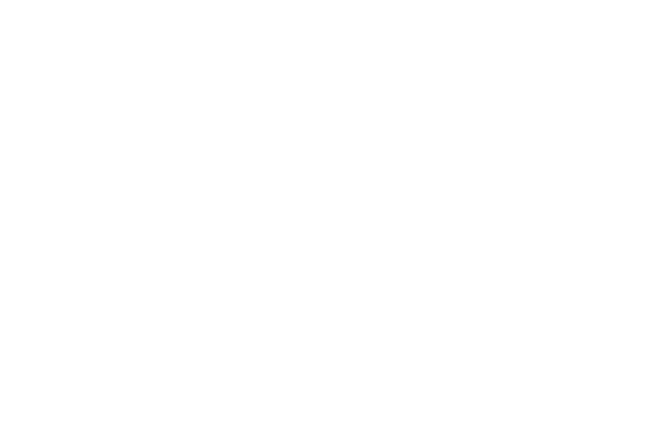

tensor([[-0.0069,  0.3861,  1.0752,  0.3861,  0.3861,  0.7792],
        [ 0.3861,  0.3861,  0.6880,  0.1260, -0.4000,  0.0631]],
       dtype=torch.float64)
tensor([[ 0.4033, -0.0139, -0.4000,  1.5364,  1.5364, -0.4000],
        [ 0.7963,  0.7262, -0.4000,  0.1190,  0.0102, -0.3369]],
       dtype=torch.float64)
tensor([[ 0.0033,  0.3963,  0.9952, -0.4000, -0.0069,  1.9231],
        [ 0.3861, -0.0069,  0.1089, -0.2810, -0.3898, -0.7369]],
       dtype=torch.float64)
tensor([[ 0.4135, -0.0037, -0.4000,  1.0902,  1.4832, -0.4000],
        [-0.0139,  0.5327, -0.2911, -0.6810, -0.7898, -1.0000]],
       dtype=torch.float64)
tensor([[ 0.0135,  0.4066,  1.1402, -0.4000, -0.4000,  1.1545],
        [ 0.3963,  0.1327, -0.6911, -1.0000, -1.0000, -1.0000]],
       dtype=torch.float64)
tensor([[ 0.4237,  0.0066, -0.4000,  1.1710,  1.1710, -0.4000],
        [-0.0037,  0.6724, -1.0000, -1.0000, -1.0000, -1.0000]],
       dtype=torch.float64)
tensor([[ 0.0237,  0.4168,  1.1918, -0.4000, -0.4000,  2.0

<IPython.core.display.Javascript object>


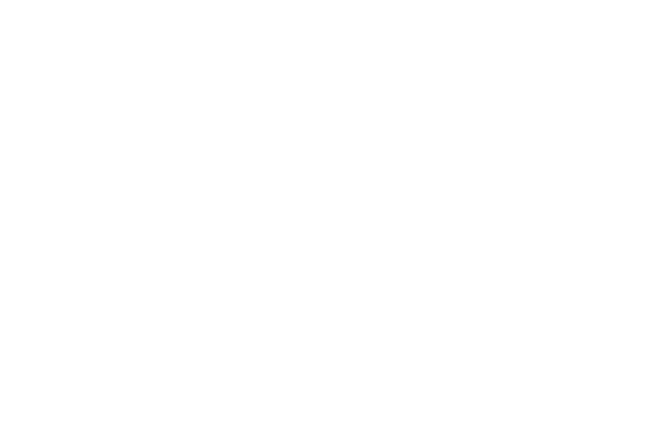

In [25]:
for m in matrices:
    print(m[2])
    plt.plot(m[2])
    plt.show()

<IPython.core.display.Javascript object>


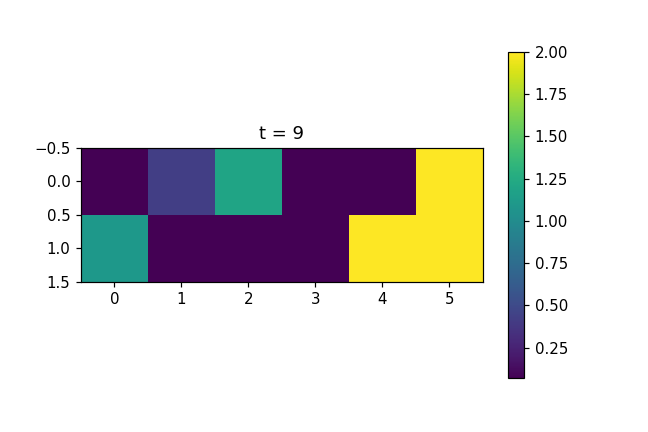

In [27]:
%matplotlib notebook
%matplotlib notebook

imagelist = [np.array(m[2]) for m in matrices]

fig = plt.figure() # make figure

im = plt.imshow(imagelist[0])
plt.colorbar()

# function to update figure
def updatefig(i):
    # set the data in the axesimage object
    im.set_array(imagelist[i])
    
    plt.title(f"t = {i}")
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(len(imagelist)), 
                              interval=400, blit=True) #interval is delay between frams in ms
plt.show()

In [515]:
# Same as one step from above: with more explanation.

# firing = f_val >= fire_threshold
# print(f'firing:{firing}')
# print(f'f_val:{f_val}')
# f_val[firing] = 0
# print(f'f_val:{f_val}')
# f_val = f_val.double() + NT@firing.double()
# print(f_val)
# fire_history = fire_history+1
# print(fire_history)
# fire_history<=apply_threshold # these neurons fired previously to this tic...
# # but the question is if their connections were of use.
# # what I need to do is look at the neurons that are currently
# # firing, see what connections they came from (by masking)
# # Importance matrix transposed (<< note that I am keeping
# # the weights in the importance matrix, not just using the bool
# # values of 'connected' or 'not connected' in order that the things
# # that played a big part in good will be strengthened greatly,
# # and those that did not will be only strengthened a little.)
# print(firing.float())
# print(I[firing])
# recently_fired = fire_history<=apply_threshold # boolean indecies of the neurons that recently fired

# # create a mask using the outer
# # product to find connections where both a neuron
# # is currently firing, and the previous neuron recently fired
# to_strengthen = torch.ger(firing.float(),recently_fired.float()).bool() 

# # use torch.repeat to create a matrix with constant
# # columns that represents how long ago that neuron fired        
# recent_fire_matrix = (fire_history).repeat(1,12).view(12,12) 

# # Now strengthen the connections by increasing the importance
# # matrix by a scaled version of how long ago that neuron fired
# I[to_strengthen] = I[to_strengthen] + strengthen_const/recent_fire_matrix.double()[to_strengthen] 

# fruitlessly_fired = fire_history==apply_threshold+1 

# # boolean indecies of the neurons that fired long ago
# # I want to weaken the connections from 
# # these neurons that didn't have an effect
# to_weaken = torch.ger(recently_fired.float(),fruitlessly_fired.float()).bool()

# # I will weaken the I matrix by a constant, rather than scaling it as I do with growth.
# I[to_weaken] = I[to_weaken] + weaken_const

# I = I.clamp(minimum_importance,saturated_importance)

# NT = torch.tensor(fun_v(I))

# print(fire_history)
# fire_history[firing] = 0
# print(fire_history)

In [ ]:
# TODO:
# Add 'inhibitory' neurons in parallel with the 'excitatory'
# ones - try them all equal in parallel to start.
#
# Add refractory period for neurons (250 ms in life)
# Add ability for neurons to form new connections/break old ones.
# Make sure the visualizations and the internal structure of the
# lattice and neurons are the same across numpy, pytorch, and plt.